In [7]:
import torch
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data.dataset import Dataset
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from getdata import CrossValidation, GetData

In [2]:
## Custom Image Dataset to import training data into PyTorch

class ImageDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.dataset = dataset
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):

        data = self.dataset[index]
        label = self.labels[index]

        if self.transform:
            data = self.transform(data)

        return data, label

In [3]:
## Testing requires the absence of the labels, so it has it's own Class

class TestImageDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, index):
        data = self.dataset[index]

        if self.transform:
            data = self.transform(data)

        return data

In [4]:
## The image collector gets the data, and formats it correctly for usage. 
## We also perform any necessary additional transformations here

class ImageGetter:

    def __init__(
        self,
        dataset_modifier='_int',
        as_image=False,
        transform=False,
        augment=False
    ):
        self.dataset_modifier = dataset_modifier
        self.as_image = as_image
        self.transform = transform
        self.augment = augment

    def kaggle(self, mean, std_dev):
        data_getter = GetData()

        train_x, train_y = data_getter.load_training(
            dataset_modifier=self.dataset_modifier,
            as_image=self.as_image,
            transform=self.transform,
            augment=self.augment
        )

        test_x = data_getter.load_test(
            as_image=self.as_image,
            transform=self.transform
        )

        train_x = train_x.reshape((-1, 64, 64, 1))
        train_y = train_y.flatten()
        test_x = test_x.reshape((-1, 64, 64, 1))

        print('dataset loaded successful for kaggle')

        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std_dev,)),
        ])

        trainset = ImageDataset(
            train_x,
            train_y,
            transform=tensor_transform
        )

        testset = TestImageDataset(
            test_x,
            transform=tensor_transform
        )

        trainloader = torch.utils.data.DataLoader(
            trainset,
            shuffle=True,
            batch_size=8,
            num_workers=2
        )

        testloader = torch.utils.data.DataLoader(
            testset,
            batch_size=8,
            num_workers=2
        )

        return trainloader, testloader

    def process(self, mean, std_dev):
        cv = CrossValidation(
            dataset_modifier=self.dataset_modifier,
            transform=self.transform,
            as_image=True,
            augment=self.augment
        )
        train_x, train_y, valid_x, valid_y = cv.get_set()
        print('data loaded successfully')

        train_x = train_x.reshape((-1, 64, 64, 1))
        valid_x = valid_x.reshape((-1, 64, 64, 1))

        tensor_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((mean,), (std_dev,)),
        ])

        trainset = ImageDataset(
            train_x,
            train_y,
            transform=tensor_transform
        )

        testset = ImageDataset(
            valid_x,
            valid_y,
            transform=tensor_transform
        )

        trainloader = torch.utils.data.DataLoader(
            trainset,
            batch_size=8,
            num_workers=4
        )

        testloader = torch.utils.data.DataLoader(
            testset,
            batch_size=8,
            num_workers=4
        )

        return trainloader, testloader

In [5]:
## The neural network itself, pretty simple

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(10*13*13, 100)
        self.fc2 = nn.Linear(100, 10)
        print('NN initialized...')

    def forward(self, x):
        #print(x.shape)

        conv = self.conv1(x)
        pool = self.pool(conv)
        x = F.relu(pool)
        #print(x.shape)

        conv = self.conv2(x)
        pool = self.pool(conv)
        x = F.relu(pool)

        #print(x.shape)
        # 4 is the batch size
        x = x.view(-1, 10*13*13)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


8
28 (8, 24)


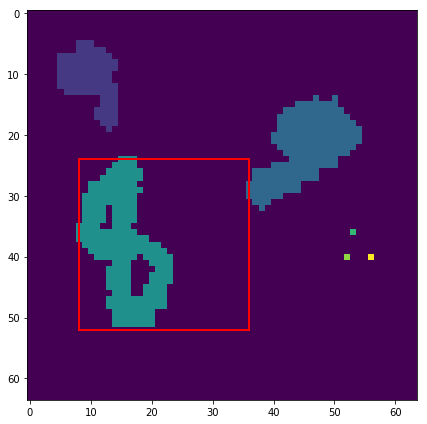

(28, 28)
28


In [6]:

class CNN:

    def __init__(self, trainloader, testloader):
        self.trainloader = trainloader
        self.testloader = testloader

        self.net = Net()

        self.criterion = nn.CrossEntropyLoss()

    def run(self, epochs, learning_rate, momentum):

        test_results = []

        for epoch in range(1, epochs):
            self.train(epoch, learning_rate, momentum, print_train_statistics=False)
            result = self.test(epoch, print_test_statistics=True)

            test_results.append(result)

        best_results = max(test_results, key=lambda t: t[3])

        print('Maximum Accuracy: {:.0f}%, average loss: {}, at epoch {}, correct: {}'.format(
            best_results[3] * 100.,
            best_results[1],
            best_results[0],
            best_results[2]
        ))

    def train(self, epoch, learning_rate, momentum, print_train_statistics=False):
        optimizer = optim.SGD(
            self.net.parameters(),
            lr=learning_rate,
            momentum=momentum
        )

        running_loss = 0.0
        self.net.train()

        for batch_index, (data, target) in enumerate(self.trainloader):
            data, target = Variable(data), Variable(target).type(torch.LongTensor)
            optimizer.zero_grad()
            output = self.net(data)

            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            # print statistics
            if print_train_statistics:
                running_loss += loss.data[0]
                if batch_index % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_index + 1, running_loss / 2000))
                    running_loss = 0.0

    def kaggle_train(self, epochs, learning_rate, momentum):
        for epoch in range(1, epochs):
            self.train(epoch, learning_rate, momentum,
                       print_train_statistics=True)

    def kaggle_test(self, epoch, print_test_statistics=False, kaggle=False):
        self.net.eval()

        predicted_labels = np.zeros(
            len(self.testloader)*self.testloader.batch_size
        )

        for index, data in enumerate(self.testloader):

            data = Variable(data, volatile=True)
            output = self.net(data)

            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]

            batch_size = self.testloader.batch_size
            batch_label = pred.numpy().flatten()
            predicted_labels[index*batch_size:(index+1)*batch_size] = batch_label

        return predicted_labels

    def test(self, epoch, print_test_statistics=False):
        self.net.eval()
        test_loss = 0
        correct = 0

        predicted_labels = np.zeros(
            len(self.testloader)*self.testloader.batch_size
        )

        for index, (data, target) in enumerate(self.testloader):

            data = Variable(data, volatile=True)
            target = Variable(target).type(torch.LongTensor)
            output = self.net(data)

            # sum up batch loss
            test_loss += F.nll_loss(
                output,
                target,
                size_average=False
            ).data[0]

            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]

            batch_size = self.testloader.batch_size
            batch_label = pred.numpy().flatten()
            predicted_labels[index*batch_size:(index+1)*batch_size] = batch_label

            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

        test_loss /= len(self.testloader.dataset)

        if print_test_statistics:
            print('Epoch: {} (Test Set) :Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                epoch,
                test_loss,
                correct,
                len(self.testloader.dataset),
                100. * correct / len(self.testloader.dataset)
            ))

        return epoch, test_loss, correct, correct/len(self.testloader.dataset)


In [70]:
def _interal_testing():
    mean = 0.5
    std_dev = 0.5

    trainloader, testloader = ImageGetter(
        dataset_modifier='_int',
        transform=True,
        augment=False
    ).process(mean, std_dev)

    learning_rate = 0.0012
    momentum = 0.9

    cnn = CNN(trainloader, testloader).run(10, learning_rate, momentum)

def _go_time():
    mean = 0.5
    std_dev = 0.5

    trainloader, testloader = ImageGetter(
        as_image=True,
        transform=True,
        augment=False
    ).kaggle(mean, std_dev)

    learning_rate = 0.001
    momentum = 0.9

    cnn = CNN(trainloader, testloader)
    cnn.kaggle_train(10, learning_rate, momentum)
    predictions = cnn.kaggle_test(10, print_test_statistics=True)

    print('writing data to file...')
    dt = pd.DataFrame(data=predictions)
    dt.columns = ["Label"]
    dt = dt.astype(int)
    dt.to_csv('../output/cnn_test.csv', mode='w',index=True, index_label='Id')

if __name__ == '__main__':
    _interal_testing()
    #_go_time()


NameError: name 'largest_digit_zoom_reshaped' is not defined

2
(21, 17)
<class 'numpy.ndarray'>


ValueError: too many values to unpack (expected 2)

In [12]:
trainset[0][0].shape

torch.Size([1, 64, 64])

In [13]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 10, 5)
        self.fc1 = nn.Linear(10*13*13, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #print(x.shape)
        
        conv = self.conv1(x)
        pool = self.pool(conv)
        x = F.relu(pool)
        #print(x.shape)
        
        conv = self.conv2(x)
        pool = self.pool(conv)
        x = F.relu(pool)

        #print(x.shape)
        # 4 is the batch size
        x = x.view(-1, 10*13*13)
        
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
class CNN:
    def __init__(self,)

In [14]:
net = Net()

In [15]:
import torch.optim as optim
from torch.autograd import Variable

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

def train(epoch, print_statistics):
    running_loss = 0
    net.train()
    
    for batch_index, (data, target) in enumerate(trainloader):
        data, target = Variable(data), Variable(target).type(torch.LongTensor)
        optimizer.zero_grad()
        output = net(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        if print_statistics:
            running_loss += loss.data[0]
            if batch_index % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (epoch + 1, batch_index + 1, running_loss / 2000))
                running_loss = 0.0

In [16]:
def test():
    net.eval()
    test_loss = 0
    correct = 0
    
    for data, target in testloader:
        data, target = Variable(data, volatile=True), Variable(target).type(torch.LongTensor)
        output = net(data)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(testloader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(testloader.dataset), 100. * correct / len(testloader.dataset)))

In [17]:
for epoch in range(1, 10):
    train(epoch, False)
    test()


Test set: Average loss: 2.2070, Accuracy: 1671/10000 (17%)


Test set: Average loss: 1.9861, Accuracy: 2771/10000 (28%)


Test set: Average loss: 1.7830, Accuracy: 3703/10000 (37%)


Test set: Average loss: 1.7240, Accuracy: 3942/10000 (39%)


Test set: Average loss: 1.5044, Accuracy: 4958/10000 (50%)


Test set: Average loss: 1.4961, Accuracy: 4921/10000 (49%)


Test set: Average loss: 1.4050, Accuracy: 5308/10000 (53%)


Test set: Average loss: 1.3515, Accuracy: 5462/10000 (55%)


Test set: Average loss: 1.3785, Accuracy: 5407/10000 (54%)

